Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

## Folder dir for saving and loading files

In [160]:
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
#model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
# model_name = 'mtm_4links_parallel'
# model_name = 'mtm_3links_parallel'

#model_name = 'psm_simple'
#model_name = 'psm_simple_coupled'
#model_name = 'psm_complete'
model_name = 'psm_complete_coupled2'


model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [161]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []


if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    friction_type = ['Coulomb', 'viscous', 'offset']
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    #springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print("MTM")
elif model_name == 'mtm_spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring_tendon':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    tendon_couplings = [(4, 3, 2.0/3.0)] # tau_3 += 2/3*tau_4
    print(model_name)
elif model_name == 'mtm_3links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q4
    q5 = -q4 + q2
    q6 = q4 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,4],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.2794, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   1,  [5],    0,     -_pi/2, 0,        q4+_pi,   True,  False, True),
          (5,   4,  [6],   0.1,   0,      0,        q5-_pi/2, True,  False, True),
          (6,   5,  [],     0.2794, 0,      0,        q6,      False, False, True)]
    friction_type = ['Coulomb', 'viscous', 'offset']
    #springs = [q1, q2, q3]
elif model_name == 'mtm_4links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q5
    q6 = -q5 + q2
    q7 = q5 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,5],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [0],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   1,  [6],     0,     -_pi/2, 0,        q5+_pi,   True,  False, True),
          (6,   5,  [7],   0.1,   0,      0,        q6-_pi/2, True,  False, True),
          (7,   6,  [],     0.279, 0,      0,        q7,      False, False, True)]
    friction_type = ['Coulomb', 'viscous']
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    # springs = [q1]
    friction_type = ['Coulomb', 'viscous']
elif (model_name == 'psm_simple'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*12
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [12,13],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
    
    
elif (model_name == 'psm_simple_coupled'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    x = [None]*15
    x[0]  = ( 0,  -1,  [1, 13, 14],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11, 12],          0, sympy.pi/2,     0,          -sympy.pi/2 + q8, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [],  -0.0091 , sympy.pi/2,     0,          -sympy.pi/2 + q9, False,  False,  True) # Tool Yaw1
    x[12] = (12,  10, [],  -0.0091 , sympy.pi/2,     0,          -sympy.pi/2 + q10, False,  False,  True) # Tool Yaw2
    x[13] = (13,  0, [],  0 , 0,     0,          q6, False,  True,  False) # Tool Yaw1 inert
    x[14] = (14,  0, [],  0 , 0,     0,          q7, False,  True,  False) # Tool Yaw2 inert
    
    
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    
    springs = [-q4]
    print(model_name)
    
elif (model_name == 'psm_complete'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*15
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [15,16],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[15] = (15,  14, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[16] = (16,  15, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
    
    
elif (model_name == 'psm_complete_coupled2'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    q8 = 1.0186 * q5
    q9 = -0.8306 * q5 + 1.2178 * q6
    q10 = -0.8306 *q5 + 1.2178 * q7
    
    x = [None]*19
    x[0]  = ( 0,  -1,  [1, 16, 17, 18],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14, 15],          0, sympy.pi/2,     0,          -sympy.pi/2 + q8, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [],  -0.0091 -0.1, sympy.pi/2,     0,          -sympy.pi/2 + q9, False,  False,  True) # Tool Yaw1
    x[15] = (15,  13, [],  -0.0091 -0.1, sympy.pi/2,     0,          -sympy.pi/2 + q10, False,  False,  True) # Tool Yaw2
    x[16] = (16,  1, [],  0 , 0,     0,          q6, False,  True,  True) # Tool Yaw1 inert
    x[17] = (17,  1, [],  0 , 0,     0,          q7, False,  True,  True) # Tool Yaw2 inert
    x[18] = (18,  1, [],  0 , 0,     0,          q10-q9, False,  False,  True) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    springs = [-q4]
    print(model_name)
     
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

psm_complete_coupled2
['Coulomb', 'viscous', 'offset']


In [162]:
robot_def.dq_for_frame

In [163]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [164]:
robot_def.bary_params

In [165]:
robot_def.K

## Create kinematics chain

In [166]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
CPU times: user 13min 50s, sys: 4.31 s, total: 13min 55s
Wall time: 13min 51s


In [175]:
angle = [0, 0, 0, 0, -.5, 0.0, 0.0]
geom.draw_geom(angle)

## Create dynamics

In [176]:
dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/18
Calculating the link kinetic energy of 3/18
Calculating the link kinetic energy of 4/18
Calculating the link kinetic energy of 6/18
Calculating the link kinetic energy of 7/18
Calculating the link kinetic energy of 8/18
Calculating the link kinetic energy of 9/18
Calculating the link kinetic energy of 11/18


KeyboardInterrupt: 

In [169]:
robot_def.bary_params

In [170]:
robot_def.dd_coordinates

In [171]:
robot_def.ddq_for_frame[8].free_symbols.pop()

In [172]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [173]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 49 parameters


In [174]:
for tendon_coupling in dyn.rbt_def.tendon_couplings:
    src_frame, dst_frame, k = tendon_coupling
    dq_src = dyn.rbt_def.dq_for_frame[src_frame]
    dq_dst = dyn.rbt_def.dq_for_frame[dst_frame]
    src_index = dyn.rbt_def.d_coordinates.index(dq_src)

    for a in range(len(dyn.rbt_def.d_coordinates)):
        dq_da = sympy.diff(dq_dst, dyn.rbt_def.d_coordinates[a])
        #tau_c[a] += dq_da * k * tau_csf[src_index]
        print(a, dq_da, k)
dyn.rbt_def.tendon_couplings 
2/3

---
# 3 - Excitation trajectory optimization

In [9]:
# model_name = 'test_psm_long2'
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
#model_name = 'mtm_spring'
# model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
#model_name = 'mtm_3links_parallel'
# model_name = 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_simple_coupled'
#model_name = 'psm_complete_coupled'

Load Data

In [10]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [11]:
trajectory_name = 'four'
#trajectory_name = 'two'
# trajectory_name = 'two_normalized'

In [19]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm' or model_name == 'mtm_spring'\
    or model_name == 'mtm_2spring' or model_name == 'mtm_2spring_tendon':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-40), deg2rad(195), -6*np.pi, 6*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -6*np.pi, 6*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -6*np.pi, 6*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -10*np.pi, 10*np.pi),
                         (q8, deg2rad(-9), deg2rad(39), deg2rad(-150), deg2rad(150))]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'mtm_3links':
    joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q3, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
    
    cartesian_constraints = [(1,'max',1,0.4,1),
                             (1,'min',-1,-1,-1),
                             (2,'max',1,0.4,1),
                             (2,'min',-1,-1,-1)]
    
    # MTM STUFF
#jnt_cnst = [(q1, -0.698132, 1.13446, -2, 2),(q2, -0.261799, 0.872665, -2, 2), (q3,-0.172665, 0.610865, -2, 2)]
#jnt_cnst = [(q1, -1.5, 1.5, -2, 2),(q2, -1.5, 1.5, -2, 2), (q3,-1.5, 1.5, -2, 2)]    

#crt_cnst = [(4, 'max', -0.283, 0.279, -0.25137), (4, 'min', -0.5, -0.321, -0.39137)]
#crt_cnst = [(3, 'max', -0.300, 0.3, -0.26137), (3, 'min', -0.5, -0.45, -0.53137)]
elif model_name == 'mtm_3links_parallel' or model_name == 'mtm_3links_parallel_offset':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'mtm_4links_parallel':
    joint_constraints = [(q1, deg2rad(-60), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q2, deg2rad(-12), deg2rad(62), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-32), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-90), deg2rad(195), -2*np.pi, 2*np.pi),
                         (q5, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'psm':
    pass
elif model_name == 'psm_simple_coupled':
    q_dvrk7 = (12177*q7)/10000 - (12177*q6)/10000
    q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
    q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    joint_constraints = [(q1, -1.45, 1.45, -2, 2),
                         (q2, -0.75, 0.8, -2, 2),
                         (q3,0.05,0.235,-0.4,0.4),
                         (q4,-1.5,1.5,-2,2),
                         (q5,-1.5,1.5,-3,3), 
                         (q_dvrk7, 0.15, np.pi,-3,3),
                         (q_mod6, -1.5, 3,-3,3),
                          (q_mod7, -3, 1.5,-3,3)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
cond: 210.985740882
cond: 210.985747127
cond: 210.98573398
cond: 210.985744172
cond: 210.985758163
cond: 210.985752104
cond: 210.985749206
cond: 210.985741141
cond: 210.985760944
cond: 210.9857505
cond: 210.985751642
cond: 210.98574567
cond: 210.985737237
cond: 210.985731538
cond: 210.985698421
cond: 210.985733269
cond: 210.98573046
cond: 210.985728668
cond: 210.985743298
cond: 210.985754696
cond: 210.985752709
cond: 210.985783657
cond: 210.985769139
cond: 210.985761763
cond: 210.985760937
cond: 210.985757532
cond: 210.98574957
cond: 210.985701811
cond: 210.985720757
cond: 210.985746151
cond: 210.985748008
cond: 210.985749768
cond: 210.985748147
cond: 210.985746473
cond: 210.985780629
cond: 210.985753095
cond: 210.985750562
cond: 210.985754212
cond: 210.985751377
cond: 210.985749971
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
cond: 210.985740882
con

cond: 500.508662043
cond: 500.5086607
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
cond: 500.508657151
co

cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 417.143031067
cond: 623.225061485
cond: 446.692001547
cond: 412.006101441
cond: 412.005934632
cond: 412.006105596
cond: 412.006200019
cond: 412.005923132
cond: 412.006126218
cond: 412.006031358
cond: 412.006129499
cond: 412.005786622
cond: 412.00613393
cond: 412.006141264
cond: 412.00616085
cond: 412.006183117
cond: 412.006249445
cond: 412.007314403
cond: 412.006007328
cond: 412.005987312
cond: 412.006031525
cond: 412.005994747
cond: 412.006083121
cond: 412.00599551
cond: 412.005094346
cond: 412.006026198
cond: 412.006306577
cond: 412.006246604
cond: 412.006228539
cond: 412.006062546
cond: 412.006094911
cond: 412.006244901
cond: 412.006100122
cond: 412.006166217
cond: 412.006116012
con

cond: 384.823932322
cond: 384.824003301
cond: 384.824074787
cond: 384.824099439
cond: 384.824189186
cond: 384.824105111
cond: 384.823346173
cond: 384.824206158
cond: 384.824403153
cond: 384.824333453
cond: 384.824308367
cond: 384.824143221
cond: 384.824194858
cond: 384.824247182
cond: 384.824193867
cond: 384.824220665
cond: 384.824193081
cond: 384.824211277
cond: 384.82418792
cond: 384.824197943
cond: 384.824183243
cond: 384.824196693
cond: 384.824181522
cond: 384.824190461
cond: 384.824203425
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
cond: 384.824196283
c

cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 365.30433919
cond: 208.404367598
cond: 296.028246112
cond: 324.65238191
cond: 324.652400468
cond: 324.652543792
cond: 324.652266395
cond: 324.652409639
cond: 324.652367602
cond: 324.652375874
cond: 324.652414733
con

cond: 325.455680308
cond: 325.455687838
cond: 325.455537182
cond: 325.455558142
cond: 325.45572273
cond: 325.455686877
cond: 325.455682881
cond: 325.456538728
cond: 325.455556295
cond: 325.455541591
cond: 325.455573808
cond: 325.455569352
cond: 325.455628385
cond: 325.45556024
cond: 325.454818598
cond: 325.455619972
cond: 325.455820491
cond: 325.455782676
cond: 325.455745048
cond: 325.455592102
cond: 325.455614759
cond: 325.455672332
cond: 325.455623197
cond: 325.455654161
cond: 325.455632431
cond: 325.455616783
cond: 325.455595203
cond: 325.455593195
cond: 325.45560225
cond: 325.455652975
cond: 325.455637225
cond: 325.455648916
cond: 325.45560599
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond: 325.455628797
cond

cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 314.477794009
cond: 309.483606216
cond: 307.496887761
cond: 307.496952854


cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 305.703145421
cond: 330.268473858
cond: 306.642513328
cond: 306.003151437
cond: 305.805063064
cond: 305.804992593
cond: 305.805075374
cond: 305.80515419
cond: 305.805119332
cond: 305.805016141
cond: 305.804965749
cond: 305.805110449
cond: 305.804970768
cond: 305.804979537
cond: 305.805106275
cond: 305.805163066
cond: 305.805085365
cond: 305.805115954
cond: 305.805962104
cond: 305.805050417
cond: 305.805009085
cond: 305.80501285
cond: 305.804992319
cond: 305.805040954
cond: 305.804987773
cond: 305.804285953
cond: 305.805048584
cond: 305.805248118
cond: 305.805208276
cond: 305.805167106
cond: 305.805023763
cond: 305.805045998
cond: 305.805107976
cond: 305.805058116
cond: 305.80508644
cond: 305.80506677
cond: 305.805051457
cond: 305.80503983
cond: 305.805028492
cond: 305.805037155
cond: 305.805085149
cond: 305.805067092
cond: 305.805065834
cond: 305.805037552
cond:

cond: 300.35528086
cond: 300.355284403
cond: 300.355273568
cond: 300.355288384
cond: 300.35527671
cond: 300.355298237
cond: 300.355291078
cond: 300.355297276
cond: 300.355276751
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
cond: 300.355287107
co

cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 299.313038453
cond: 549.429072255
cond: 374.883914726
cond: 303.633441599
cond: 299.204460655
cond: 299.204455191
cond: 299.204506202
cond: 299.204460174
cond: 299.204401495
cond: 299.204383993
cond: 299.20440076
cond: 299.204479192
cond: 299.204414059
cond: 299.204471923
cond: 299.204501728
cond: 299.204489132
cond: 299.204454074
cond: 299.204533842
cond: 299.205328922
cond: 299.204443147
cond: 299.204420516
c

cond: 299.095918171
cond: 299.095903658
cond: 299.095969689
cond: 299.095919127
cond: 299.095860421
cond: 299.09584131
cond: 299.09585681
cond: 299.095936908
cond: 299.095868922
cond: 299.095929659
cond: 299.09596009
cond: 299.095946035
cond: 299.095909257
cond: 299.095989851
cond: 299.096787625
cond: 299.095899369
cond: 299.09587689
cond: 299.095875413
cond: 299.095855512
cond: 299.095882984
cond: 299.095843311
cond: 299.095140278
cond: 299.095873194
cond: 299.096065848
cond: 299.096038276
cond: 299.096016995
cond: 299.095880246
cond: 299.095900837
cond: 299.095941469
cond: 299.095910052
cond: 299.095930228
cond: 299.095914317
cond: 299.095909085
cond: 299.095903706
cond: 299.095905011
cond: 299.095904837
cond: 299.095934718
cond: 299.095921514
cond: 299.095932598
cond: 299.095900398
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond: 299.095918171
cond

cond: 118.936524858
cond: 118.936526109
cond: 118.936525643
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526186
cond: 118.936526187
cond: 118.936526186
cond: 118.936526186
cond: 118.936526187
cond: 118.936526185
cond: 118.936526183
cond: 118.936526189
cond: 118.936526184
cond: 118.936526185
cond: 118.936526187
cond: 118.936526183
cond: 118.936526185
cond: 118.936526185
cond: 118.936526186
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526184
cond: 118.936526184
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185
cond: 118.936526185


In [20]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [21]:
traj_optimizer.calc_frame_traj()

In [25]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [23]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 500
tf = 35 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [24]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.2117,-0.2284,2.3638,0.0241,3.8529,0.0647,-0.3299,-0.0269,-1.104,-0.1744,1.3729,0.21,1.3776
q2,-0.0284,-0.1867,0.0905,-0.1835,0.0563,-0.2268,0.7106,0.6018,-0.1312,-0.6209,0.0858,-0.303,0.5218
q3,0.1524,0.1,0.2504,0.3023,0.1114,-0.1436,0.0599,0.1024,-0.0204,-0.2083,-0.3015,-0.3454,0.0163
q4,0.301,-0.6228,-0.2123,0.6638,0.1955,0.3863,-0.1471,0.0784,0.6866,-0.3607,0.3601,0.1482,0.5614
q5,0.0998,-0.4981,0.656,0.3323,0.4983,-0.2354,0.3538,0.546,0.4261,1.6326,0.2325,-1.0421,0.9154
q6,-0.2705,0.6914,0.1312,0.3671,0.4374,0.2859,0.7322,0.317,1.1456,1.5541,1.1735,-0.5477,0.2054
q7,0.6206,0.22,0.3858,0.7048,0.2758,0.2773,0.6134,0.2441,0.8919,1.3162,0.3569,0.3831,0.1226


---
# Data processing

## Load data

In [177]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [178]:
# Names as Arguments
# model_name = 'test_psm_long'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
#model_name = 'mtm_2spring_tendon'

#model_name == 'mtm_3links_parallel'
# model_name == 'mtm_4links_parallel'

#model_name = 'psm_no_off_minert'
model_name = 'psm_complete_coupled2'


training_trajectory_name = 'two'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.16


In [179]:
robot_model.coordinates

### Load traning data set

In [180]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

q_raw_train[:,[5, 6]] = q_raw_train[:,[6, 5]]
dq_raw_train[:,[5, 6]] = dq_raw_train[:,[6, 5]]
tau_raw_train[:,[5, 6]] = tau_raw_train[:,[6, 5]]

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_train[:,1] = tau_raw_train[:,1] - tau_raw_train[:,2] + 0.5515/0.8235 * tau_raw_train[:, 3]
    tau_raw_train[:,2] = tau_raw_train[:,2] - 0.5515/0.8235 * tau_raw_train[:, 3]

(<type 'numpy.ndarray'>, (14999, 21))


### Load test data set

In [181]:
test_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

q_raw_test[:,[5, 6]] = q_raw_test[:,[6, 5]]
dq_raw_test[:,[5, 6]] = dq_raw_test[:,[6, 5]]
tau_raw_test[:,[5, 6]] = tau_raw_test[:,[6, 5]]

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_test[:,1] = tau_raw_test[:,1] - tau_raw_test[:,2] + 0.5515/0.8235 * tau_raw_test[:, 3]
    tau_raw_test[:,2] = tau_raw_test[:,2] - 0.5515/0.8235 * tau_raw_test[:, 3]

(<type 'numpy.ndarray'>, (14999, 21))


## Calculate filter cut-off frequency

In [182]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

#fc_mult = [1.3] #(good)
fc_mult = [2, 2, 2, 2,3, 3, 3]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)
fc.shape[0] == 1
#print("Cut frequency: {}".format(fc))

0.16
[1.92 1.92 1.92 1.92 2.88 2.88 2.88]


False

## Differentiation and filtering

### Traning data

In [183]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

[0.02412743 0.02412743 0.02412743 0.02412743 0.03619115 0.03619115
 0.03619115]
q_raw shape: (14999, 7)
plot shape: 470


### Test data

In [184]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

[0.02412743 0.02412743 0.02412743 0.02412743 0.03619115 0.03619115
 0.03619115]
q_raw shape: (14999, 7)
plot shape: 470


---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [185]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [186]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [187]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [188]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m9,0.42586245597754596
-0.36018965*l3x - 0.10779909*l3y - 0.36018965*l4x ...,0.05539939983021869
0.10779909*l3x - 0.36018965*l3y + 0.10779909*l4x -...,-0.0202781992716132
1.0*m11,0.6716998464691738
1.0*l11z + 0.59782515*l3x + 0.17891964*l3y + 0.597...,-0.16706711774361568
-0.37597504*l1y - 0.37597504*l3z - 0.37597504*l4z ...,0.003288968407010047
1.0*l11x - 0.17891964*l3x + 0.59782515*l3y - 0.178...,0.07242977631729516
1.0*l11y + 0.62402496*l1y + 0.62402496*l3z + 0.624...,-0.026808952026155797
1.0*l7y,6.293190085755084
-0.76050527*L11xx + 0.91014738*L3xx - 0.91014738*L...,0.10220546621932292


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [189]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [190]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00021732102039618794
standard deviation of xb using OLS:
[9.18245375e-05 4.86736264e-05 5.36144629e-05 2.62569735e-04
 5.10210718e-05 1.55196184e-04 8.94904535e-05 2.84166427e-04
 7.02447961e-02 2.80923059e-03 1.55405764e-04 6.15757533e-05
 2.12927077e-04 2.02089946e-04 8.37193502e-05 3.30232161e-03
 2.92916980e-05 3.61380371e-04 2.02008517e-04 3.48911223e-05
 2.19346766e-04 5.23061600e-05 2.74845371e-05 1.32241899e-03
 2.22894982e-04 4.78382074e-03 1.02441934e-04 2.69592213e-04
 6.63261011e-05 1.91346380e-04 1.45064906e-04 1.96033903e-04
 3.61296244e-02 1.25715449e-04 9.34844390e-04 4.28162514e-03
 1.30227041e-04 1.49261671e-03 1.68944115e-04 1.64926502e-04
 1.67535285e-04 2.63418226e-04 2.69381743e-04 1.97572447e-04
 2.06675688e-04 2.07107333e-04 2.12628900e-04 1.84864257e-04
 1.05795620e-01]
percentage of standard deviation of xb using OLS: 
[2.15620176e-04 8.78594831e-04 2.64394595e-03 3.90903373e-04
 3.05392662e-04 4.71868881e-02 1.2355478

### Plot measured torque and predicted torque

In [191]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [192]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

In [193]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [194]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11831201, 0.19800487, 0.17420303, 0.15318861, 0.32779558,
       0.2437024 , 0.16069445])

## Weighted Least Square (WLS)

### Training data set

In [195]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight

array([2.16471679, 2.49493121, 4.16037281, 0.0120729 , 0.08119699,
       0.06389022, 0.0698551 ])

In [196]:
W_b_train.shape, tau_s_train.shape

In [197]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [198]:
weights.shape

In [199]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [200]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [201]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [202]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

In [203]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [204]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07010929, 0.16331972, 0.1485486 , 0.13364022, 0.26926187,
       0.25293002, 0.20367576])

In [205]:
robot_model.bary_param

In [206]:
robot_def.d_coordinates[0] != robot_def.dq_for_frame[1]

False

In [207]:
robot_model.coordinates[1].name[1:]

'2'

### Test data set

In [208]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [209]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10838631, 0.1899638 , 0.17515243, 0.15318861, 0.32818696,
       0.24319981, 0.16185786])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [40]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [41]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [42]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [43]:
sdp_constraints = []
spring_constraints = []
if model_name == 'mtm' or model_name == 'mtm_2spring_tendon':
    sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2),
                      (1, 10, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2),
                      (1, 10, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.2, 0.2, 0.2),
                      (0.2, 5, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.2, 0.2, 0.1),
                      (0.1, 2, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (1, 10, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.1, 0.2, 0.2),
                      (0.05, 0.5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.1, 0.1, 0.0)]
    spring_constraints = [(250, 300), (0.001, 0.1)]
elif model_name == 'mtm_3links':
    sdp_constraints = [(0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.5, 0.5, 0.5),
                      (0.3, 5, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.1, 3, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.1, 0.5, 0.5),
                      (0.1, 1, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.3, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.2, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.01, 0.1, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (0.3, 5, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1)]
else:
    raise Exception("No robot name matches " + model_name)

In [57]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (102123, 122)
Regressand shape: (102123,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4727149, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
Variables n = 123, constraints m = 102451
Cones:	linear vars: 137
	soc vars: 102125, soc blks: 1
	sd vars: 189, sd blks: 9
Setup time: 1.93e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.39e+01  9.74e-01  1.00e+00 -1.02e+04 -2.26e-03  5.06e-12  2.32

  9400| 8.11e-02  2.56e-05  2.82e-04  4.45e-01  4.45e-01  2.11e-12  5.98e+02 
  9500| 8.11e-02  1.20e-05  2.86e-04  4.49e-01  4.50e-01  4.21e-13  6.04e+02 
  9600| 8.11e-02  4.14e-05  2.89e-04  4.54e-01  4.55e-01  2.11e-12  6.10e+02 
  9700| 8.11e-02  6.02e-05  2.95e-04  4.59e-01  4.59e-01  2.11e-12  6.15e+02 
  9800| 8.10e-02  7.32e-05  3.01e-04  4.63e-01  4.64e-01  4.21e-13  6.20e+02 
  9900| 8.10e-02  7.41e-05  3.06e-04  4.68e-01  4.69e-01  4.21e-13  6.26e+02 
 10000| 8.11e-02  6.43e-05  3.09e-04  4.73e-01  4.73e-01  1.26e-12  6.31e+02 
 10100| 8.11e-02  4.79e-05  3.13e-04  4.77e-01  4.78e-01  2.95e-12  6.37e+02 
 10200| 8.11e-02  2.24e-05  3.18e-04  4.82e-01  4.83e-01  2.11e-12  6.42e+02 
 10300| 8.11e-02  1.49e-05  3.23e-04  4.87e-01  4.88e-01  4.21e-13  6.47e+02 
 10400| 8.11e-02  3.03e-05  3.28e-04  4.92e-01  4.92e-01  1.26e-12  6.53e+02 
 10500| 8.11e-02  4.94e-05  3.31e-04  4.96e-01  4.97e-01  2.95e-12  6.58e+02 
 10600| 8.10e-02  6.10e-05  3.35e-04  5.01e-01  5.02e-01  1.26e-

 20000| 8.10e-02  3.00e-06  6.10e-04  9.43e-01  9.45e-01  4.21e-13  1.13e+03 
 20100| 8.10e-02  7.14e-06  6.12e-04  9.48e-01  9.49e-01  4.21e-13  1.14e+03 
 20200| 8.10e-02  5.26e-06  6.14e-04  9.52e-01  9.54e-01  2.95e-12  1.14e+03 
 20300| 8.10e-02  8.82e-06  6.16e-04  9.57e-01  9.59e-01  4.21e-13  1.15e+03 
 20400| 8.10e-02  9.51e-06  6.18e-04  9.62e-01  9.64e-01  4.21e-13  1.15e+03 
 20500| 8.10e-02  8.59e-06  6.20e-04  9.66e-01  9.68e-01  4.21e-13  1.16e+03 
 20600| 8.10e-02  9.54e-06  6.22e-04  9.71e-01  9.73e-01  4.21e-13  1.16e+03 
 20700| 8.10e-02  5.09e-06  6.24e-04  9.76e-01  9.78e-01  4.21e-13  1.17e+03 
 20800| 8.10e-02  6.79e-06  6.26e-04  9.81e-01  9.82e-01  4.21e-13  1.17e+03 
 20900| 8.10e-02  3.99e-06  6.28e-04  9.85e-01  9.87e-01  1.26e-12  1.18e+03 
 21000| 8.10e-02  5.73e-06  6.29e-04  9.90e-01  9.92e-01  2.95e-12  1.18e+03 
 21100| 8.10e-02  7.98e-06  6.31e-04  9.95e-01  9.97e-01  1.26e-12  1.18e+03 
 21200| 8.10e-02  6.89e-06  6.33e-04  9.99e-01  1.00e+00  1.26e-

 30600| 8.09e-02  4.20e-06  7.56e-04  1.44e+00  1.44e+00  1.27e-12  1.66e+03 
 30700| 8.09e-02  2.63e-06  7.57e-04  1.45e+00  1.45e+00  2.11e-12  1.67e+03 
 30800| 8.09e-02  3.41e-06  7.58e-04  1.45e+00  1.45e+00  1.27e-12  1.67e+03 
 30900| 8.09e-02  3.81e-06  7.59e-04  1.45e+00  1.46e+00  4.22e-13  1.68e+03 
 31000| 8.09e-02  2.39e-06  7.59e-04  1.46e+00  1.46e+00  1.27e-12  1.68e+03 
 31100| 8.09e-02  4.30e-06  7.60e-04  1.46e+00  1.47e+00  1.27e-12  1.68e+03 
 31200| 8.09e-02  2.18e-06  7.61e-04  1.47e+00  1.47e+00  1.27e-12  1.69e+03 
 31300| 8.09e-02  3.89e-06  7.62e-04  1.47e+00  1.48e+00  2.95e-12  1.69e+03 
 31400| 8.09e-02  3.12e-06  7.63e-04  1.48e+00  1.48e+00  4.22e-13  1.70e+03 
 31500| 8.09e-02  2.84e-06  7.64e-04  1.48e+00  1.49e+00  2.11e-12  1.70e+03 
 31600| 8.09e-02  3.98e-06  7.65e-04  1.49e+00  1.49e+00  4.22e-13  1.71e+03 
 31700| 8.09e-02  2.07e-06  7.66e-04  1.49e+00  1.50e+00  2.11e-12  1.71e+03 
 31800| 8.09e-02  4.15e-06  7.67e-04  1.50e+00  1.50e+00  4.22e-

 41200| 8.08e-02  2.98e-06  8.35e-04  1.94e+00  1.94e+00  2.96e-12  2.15e+03 
 41300| 8.08e-02  3.01e-06  8.35e-04  1.94e+00  1.95e+00  4.22e-13  2.15e+03 
 41400| 8.08e-02  3.36e-06  8.36e-04  1.95e+00  1.95e+00  1.27e-12  2.16e+03 
 41500| 8.08e-02  2.70e-06  8.36e-04  1.95e+00  1.96e+00  1.27e-12  2.16e+03 
 41600| 8.08e-02  3.46e-06  8.37e-04  1.96e+00  1.96e+00  1.27e-12  2.17e+03 
 41700| 8.08e-02  2.79e-06  8.37e-04  1.96e+00  1.96e+00  4.22e-13  2.17e+03 
 41800| 8.08e-02  3.24e-06  8.38e-04  1.97e+00  1.97e+00  1.27e-12  2.17e+03 
 41900| 8.08e-02  3.16e-06  8.38e-04  1.97e+00  1.97e+00  4.22e-13  2.18e+03 
 42000| 8.08e-02  2.87e-06  8.39e-04  1.97e+00  1.98e+00  1.27e-12  2.18e+03 
 42100| 8.08e-02  3.43e-06  8.39e-04  1.98e+00  1.98e+00  4.22e-13  2.19e+03 
 42200| 8.08e-02  2.72e-06  8.40e-04  1.98e+00  1.99e+00  4.22e-13  2.19e+03 
 42300| 8.08e-02  3.39e-06  8.40e-04  1.99e+00  1.99e+00  1.27e-12  2.20e+03 
 42400| 8.08e-02  2.96e-06  8.41e-04  1.99e+00  2.00e+00  4.22e-

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [58]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [59]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.07897814, 0.31287993, 0.17930951, 0.26768465, 0.29612818,
       0.2220772 , 0.26818115])

### Plot measured torque and predicted torque

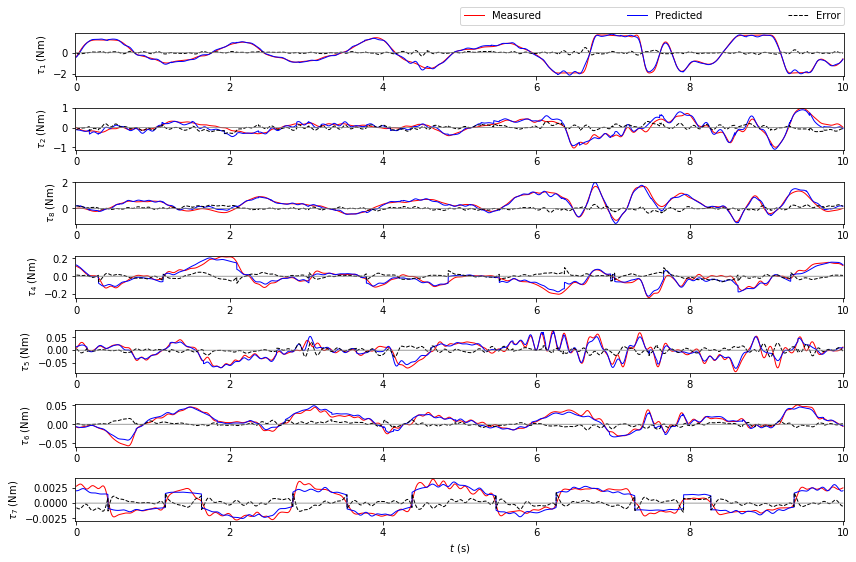

In [73]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [61]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

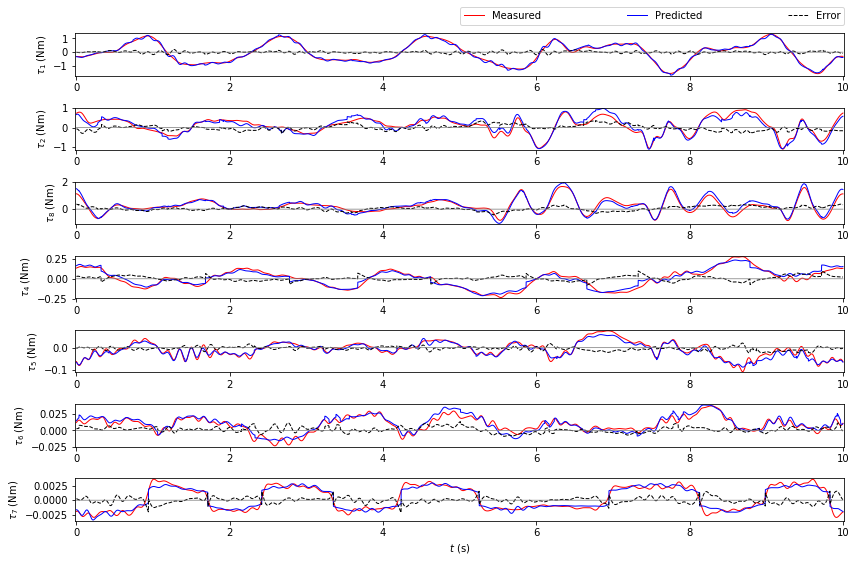

In [74]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [63]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09879577, 0.32548518, 0.28563868, 0.25714807, 0.25187338,
       0.29823386, 0.24384046])

In [64]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx     2.6343054888674   ⎤
⎢                           ⎥
⎢L1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢L1xz  9.56844769208569e-24 ⎥
⎢                           ⎥
⎢L1yy    2.63430548886742   ⎥
⎢                           ⎥
⎢L1yz  1.11467480731081e-17 ⎥
⎢                           ⎥
⎢L1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢l1x   5.85046325777972e-23 ⎥
⎢                           ⎥
⎢l1y   -1.89889430298544e-17⎥
⎢                           ⎥
⎢l1z     0.515973583715752  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢L2xx   0.0185035212076023  ⎥
⎢                           ⎥
⎢L2xy   0.00633619756614463 ⎥
⎢                           ⎥
⎢L2xz   0.00250272253380045 ⎥
⎢                           ⎥
⎢L2yy    0.013261627741961  ⎥
⎢         

In [65]:
from identification import barycentric2standard_params

In [66]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [67]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    2.56468110409537   ⎤
⎢                           ⎥
⎢I1xy  -4.46223463925424e-14⎥
⎢                           ⎥
⎢I1xz  1.74629391507553e-23 ⎥
⎢                           ⎥
⎢I1yy    2.56468110409538   ⎥
⎢                           ⎥
⎢I1yz  8.58442023763276e-18 ⎥
⎢                           ⎥
⎢I1zz   8.48601005291674e-6 ⎥
⎢                           ⎥
⎢r1x    1.5300185334718e-23 ⎥
⎢                           ⎥
⎢r1y   -4.96600585057657e-18⎥
⎢                           ⎥
⎢r1z     0.134937886297668  ⎥
⎢                           ⎥
⎢ m₁     3.82378587565491   ⎥
⎢                           ⎥
⎢Fc₁    0.0319006663095601  ⎥
⎢                           ⎥
⎢Fv₁    0.0552209852590067  ⎥
⎢                           ⎥
⎢Fo₁    -0.0608126942836563 ⎥
⎢                           ⎥
⎢I2xx   0.0176099112247765  ⎥
⎢                           ⎥
⎢I2xy   0.00433958872950056 ⎥
⎢                           ⎥
⎢I2xz   -2.8759159057212e-5 ⎥
⎢                           ⎥
⎢I2yy   0.00107829944199846 ⎥
⎢         